In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from utils import load_mnist

In [ ]:
!unzip -q MNIST.zip   #unzip the file

In [63]:
x_train, y_train, x_test, y_test = load_mnist()

print(f"Loaded {x_train.shape[0]} training images.") #loaded all images

Loaded 60000 training images.


In [64]:
def one_hot_encode(y, num_classes=10):
    #convert a single number into a vector of one and zeros( one for the correct label)
    y_int = np.array(y, dtype=int).flatten()
    return np.eye(num_classes)[y_int]

#initialize the network

In [66]:
def initialize_network(layer_sizes):
    K = len(layer_sizes) - 1 # K is the number of layers
    all_weights = [None] * K
    all_biases = [None] * K

    for k in range(K):
        n_in = layer_sizes[k]
        n_out = layer_sizes[k+1]

        # Randomly pick weights; scale them based on input size
        all_weights[k] = np.random.normal(0, np.sqrt(2.0/n_in), size=(n_out, n_in)) #He initialization as per instruction
        all_biases[k] = np.zeros((n_out, 1)) + 0.01

    return all_weights, all_biases

#Activation Function and their derivatives

In [67]:
def ReLU(x):
    return np.maximum(0, x)

def d_ReLU(x):
    return (x > 0).astype(float)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def d_sigmoid(x):
    s = sigmoid(x)
    return s * (1 - s)

#Forward Pass Function, use the equationn $F = X\Omega^T + \beta^T$. to calculate the output

In [68]:
def forward_pass(X, all_weights, all_biases, activation_type='ReLU'):
    K = len(all_weights)
    all_f = [None] * K
    all_h = [None] * (K + 1)

    act_fn = ReLU if activation_type == 'ReLU' else sigmoid
    all_h[0] = X

    for k in range(K):
        # Matrix multiplication for the layer
        all_f[k] = np.matmul(all_h[k], all_weights[k].T) + all_biases[k].T

        # Applying activation function
        if k < K - 1:
            all_h[k+1] = act_fn(all_f[k])
        else:
            all_h[k+1] = all_f[k]

    return all_f[K-1], all_f, all_h

#softmax function

In [69]:
def softmax(f):
    #turn the final layer output into probabilities
    f_shifted = f - np.max(f, axis=1, keepdims=True)
    exp_f = np.exp(f_shifted)
    return exp_f / np.sum(exp_f, axis=1, keepdims=True)

#Cost Funtion

In [70]:
def compute_cost(f_K, y_oh):
    max_f = np.max(f_K, axis=1, keepdims=True)

    #Log-Sum-Exp term
    log_sum_exp = max_f + np.log(np.sum(np.exp(f_K - max_f), axis=1, keepdims=True))

    #Full Cross-Entropy Loss
    loss_i = log_sum_exp - np.sum(y_oh * f_K, axis=1, keepdims=True)

    # 4. Return mean over the batch
    return np.mean(loss_i)

# d_cost_d_output

In [71]:
def d_cost_d_output(f_K, y_oh):
    I = f_K.shape[0]
    return (softmax(f_K) - y_oh) / I

#Backward Propagation

In [ ]:
def backward_pass(all_weights, all_biases, all_f, all_h, y_oh, activation_type='ReLU'):
    "Works backward from the error to see how to adjust each weight"
    K = len(all_weights) - 1
    all_dl_dweights = [None] * (K + 1)
    all_dl_dbiases = [None] * (K + 1)
    all_dl_df = [None] * (K + 1)
    all_dl_dh = [None] * (K + 1)

    all_dl_df[K] = d_cost_d_output(all_f[K], y_oh)

    for layer in range(K, -1, -1):
        all_dl_dweights[layer] = np.matmul(all_dl_df[layer].T, all_h[layer])
        all_dl_dbiases[layer] = np.sum(all_dl_df[layer], axis=0, keepdims=True).T

        if layer > 0:
            all_dl_dh[layer] = np.matmul(all_dl_df[layer], all_weights[layer])
            if activation_type == 'ReLU':
                all_dl_df[layer-1] = all_dl_dh[layer] * d_ReLU(all_f[layer-1])
            else:
                all_dl_df[layer-1] = all_dl_dh[layer] * d_sigmoid(all_f[layer-1])

    return all_dl_dweights, all_dl_dbiases

#Update Parameter (Take a step)

In [72]:
def update_parameters(all_weights, all_biases, grads_w, grads_b, alpha):
    for k in range(len(all_weights)):
        # Subtract the gradient scaled by alpha
        all_weights[k] = all_weights[k] - alpha * grads_w[k]
        all_biases[k] = all_biases[k] - alpha * grads_b[k]
    return all_weights, all_biases

In [73]:
def predict(X, y, all_weights, all_biases, activation_type='ReLU'):
    # forward_pass returns: f_K, all_f, all_h
    f_K, _, _ = forward_pass(X, all_weights, all_biases, activation_type)

    # Compute probabilities for accuracy
    probs = softmax(f_K)
    predictions = np.argmax(probs, axis=1)

    # Compute cost for the dataset
    y_oh = one_hot_encode(y)
    cost = compute_cost(f_K, y_oh)

    # Calculate accuracy
    accuracy = np.mean(predictions == y.flatten())
    return predictions, accuracy, cost

#Mini-batch generation

In [74]:
def random_mini_batches(X, y_oh, batch_size):
    I = X.shape[0]
    mini_batches = []

    indices = np.random.permutation(I)
    X_shuffled = X[indices]
    y_shuffled = y_oh[indices]

    for i in range(0, I, batch_size):
        X_mini = X_shuffled[i : i + batch_size]
        y_mini = y_shuffled[i : i + batch_size]
        mini_batches.append((X_mini, y_mini))

    return mini_batches

#Finally Model Training

In [76]:
def train_model(x_train, y_train_oh, x_test, y_test_oh, model_architecture,
                num_epochs=50, learning_rate=0.1, batch_size=64):

    all_weights, all_biases = initialize_network(model_architecture)

    # Get 1D labels for accuracy checks
    y_train_labels = np.argmax(y_train_oh, axis=1)
    y_test_labels = np.argmax(y_test_oh, axis=1)

    # Lists to store metrics for plotting
    train_costs, test_costs = [], []
    train_accs, test_accs = [], []

    print(f"Training {model_architecture} for {num_epochs} epochs...")

    for epoch in range(num_epochs):
        batches = random_mini_batches(x_train, y_train_oh, batch_size)

        for x_mini, y_mini_oh in batches:
            # Forward and Backward pass
            _, all_f, all_h = forward_pass(x_mini, all_weights, all_biases)
            grads_w, grads_b = backward_pass(all_weights, all_biases, all_f, all_h, y_mini_oh)

            # Update
            all_weights, all_biases = update_parameters(all_weights, all_biases, grads_w, grads_b, learning_rate)

        # Evaluation at the end of each epoch
        # Use the predict function to get metrics on full datasets
        _, t_acc, t_cost = predict(x_train, y_train_labels, all_weights, all_biases)
        _, v_acc, v_cost = predict(x_test, y_test_labels, all_weights, all_biases)

        train_costs.append(t_cost)
        test_costs.append(v_cost)
        train_accs.append(t_acc)
        test_accs.append(v_acc)

        print(f"Epoch {epoch}: Loss {t_cost:.4f}, Test Acc {v_acc:.4f}")

    return all_weights, all_biases, train_costs, test_costs, train_accs, test_accs

Training [784, 10] for 50 epochs...
Epoch 0: Loss 0.3591, Test Acc 0.9051
Epoch 1: Loss 0.3222, Test Acc 0.9143
Epoch 2: Loss 0.3038, Test Acc 0.9187
Epoch 3: Loss 0.2963, Test Acc 0.9189
Epoch 4: Loss 0.2886, Test Acc 0.9202
Epoch 5: Loss 0.2834, Test Acc 0.9204
Epoch 6: Loss 0.2792, Test Acc 0.9202
Epoch 7: Loss 0.2770, Test Acc 0.9226
Epoch 8: Loss 0.2739, Test Acc 0.9232
Epoch 9: Loss 0.2750, Test Acc 0.9223
Epoch 10: Loss 0.2706, Test Acc 0.9226
Epoch 11: Loss 0.2690, Test Acc 0.9239
Epoch 12: Loss 0.2672, Test Acc 0.9239
Epoch 13: Loss 0.2672, Test Acc 0.9249
Epoch 14: Loss 0.2634, Test Acc 0.9218
Epoch 15: Loss 0.2640, Test Acc 0.9222
Epoch 16: Loss 0.2624, Test Acc 0.9221
Epoch 17: Loss 0.2644, Test Acc 0.9234
Epoch 18: Loss 0.2614, Test Acc 0.9211
Epoch 19: Loss 0.2578, Test Acc 0.9228
Epoch 20: Loss 0.2603, Test Acc 0.9240
Epoch 21: Loss 0.2573, Test Acc 0.9227
Epoch 22: Loss 0.2560, Test Acc 0.9256
Epoch 23: Loss 0.2554, Test Acc 0.9239
Epoch 24: Loss 0.2548, Test Acc 0.9249

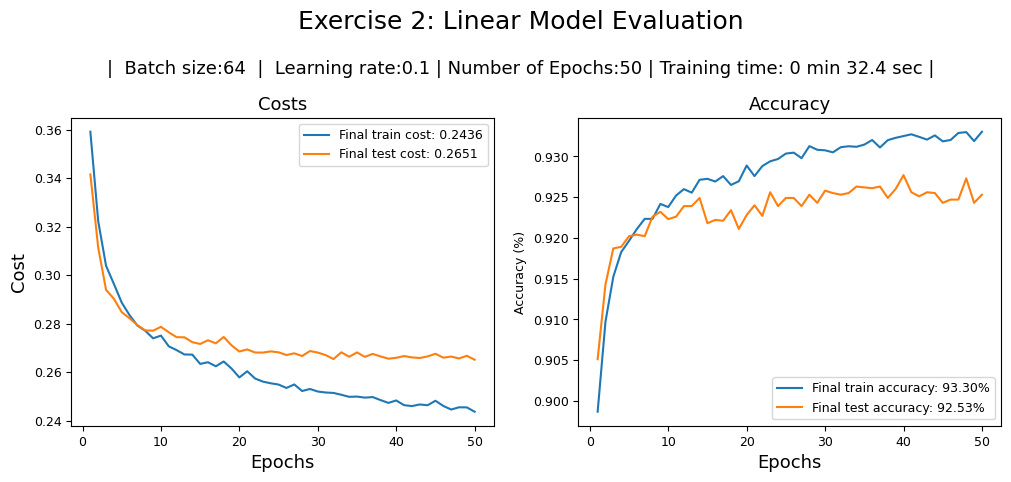

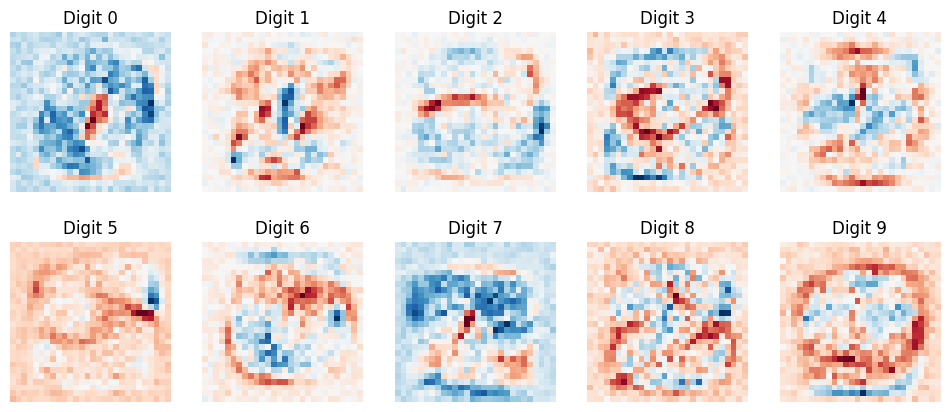

In [77]:
import time
import matplotlib.pyplot as plt
from utils import training_curve_plot

# Setup Parameters
arch_linear = [784, 10]
lr = 0.1
bs = 64
epochs = 50


start_time = time.time() #Train and track time
weights, biases, t_costs, v_costs, t_accs, v_accs = train_model(
    x_train, y_train, x_test, y_test,
    model_architecture=arch_linear,
    num_epochs=epochs,
    learning_rate=lr,
    batch_size=bs
)
elapsed_time = time.time() - start_time

#Part (a): Generate the Training Curves

training_curve_plot(
    "Exercise 2: Linear Model Evaluation",
    t_costs,
    v_costs,
    t_accs,
    v_accs,
    bs,
    lr,
    epochs,
    elapsed_time
)

# Part (b): Visualization (The 28x28 Weight Templates)
plt.figure(figsize=(12, 5))
for i in range(10):
    # weights[0] is the weight matrix for the first layer
    w_image = weights[0][i, :].reshape(28, 28)
    plt.subplot(2, 5, i+1)
    plt.imshow(w_image, cmap='RdBu')
    plt.title(f"Digit {i}")
    plt.axis('off')
plt.show()

# Exercise 3: Multi-layer Neural Network

In [58]:
def train_model(x_train, y_train_oh, x_test, y_test_oh, model_architecture,
                num_epochs=10, learning_rate=0.1, batch_size=64, activation_type='ReLU'):

    all_weights, all_biases = initialize_network(model_architecture)

    y_train_labels = np.argmax(y_train_oh, axis=1)
    y_test_labels = np.argmax(y_test_oh, axis=1)

    train_costs, test_costs = [], []
    train_accs, test_accs = [], []

    print(f"Training {model_architecture} using {activation_type} for {num_epochs} epochs...")

    for epoch in range(num_epochs):
        batches = random_mini_batches(x_train, y_train_oh, batch_size)

        for x_mini, y_mini_oh in batches:

            _, all_f, all_h = forward_pass(x_mini, all_weights, all_biases, activation_type)
            grads_w, grads_b = backward_pass(all_weights, all_biases, all_f, all_h, y_mini_oh, activation_type)

            all_weights, all_biases = update_parameters(all_weights, all_biases, grads_w, grads_b, learning_rate)


        _, t_acc, t_cost = predict_eval(x_train, y_train_labels, all_weights, all_biases, activation_type)
        _, v_acc, v_cost = predict_eval(x_test, y_test_labels, all_weights, all_biases, activation_type)

        train_costs.append(t_cost)
        test_costs.append(v_cost)
        train_accs.append(t_acc)
        test_accs.append(v_acc)

        print(f"Epoch {epoch}: Loss {t_cost:.4f}, Test Acc {v_acc:.4f}")

    return all_weights, all_biases, train_costs, test_costs, train_accs, test_accs

def predict_eval(X, y_labels, all_weights, all_biases, activation_type='ReLU'):
    f_K, _, _ = forward_pass(X, all_weights, all_biases, activation_type)
    predictions = np.argmax(f_K, axis=1)
    accuracy = np.mean(predictions == y_labels.flatten())
    y_oh = one_hot_encode(y_labels)
    cost = compute_cost(f_K, y_oh)
    return predictions, accuracy, cost

In [60]:
# Input (784) -> Hidden Layer (128) -> Output (10)
arch_mlp = [784, 128, 10]

# Training parameters
learning_rate = 0.1
batch_size = 64
num_epochs = 50

Training [784, 128, 10] using ReLU for 50 epochs...
Epoch 0: Loss 0.2330, Test Acc 0.9340
Epoch 1: Loss 0.1630, Test Acc 0.9517
Epoch 2: Loss 0.1278, Test Acc 0.9605
Epoch 3: Loss 0.1052, Test Acc 0.9663
Epoch 4: Loss 0.0889, Test Acc 0.9686
Epoch 5: Loss 0.0788, Test Acc 0.9700
Epoch 6: Loss 0.0686, Test Acc 0.9727
Epoch 7: Loss 0.0592, Test Acc 0.9748
Epoch 8: Loss 0.0684, Test Acc 0.9694
Epoch 9: Loss 0.0498, Test Acc 0.9732
Epoch 10: Loss 0.0459, Test Acc 0.9746
Epoch 11: Loss 0.0466, Test Acc 0.9752
Epoch 12: Loss 0.0393, Test Acc 0.9758
Epoch 13: Loss 0.0332, Test Acc 0.9772
Epoch 14: Loss 0.0337, Test Acc 0.9770
Epoch 15: Loss 0.0284, Test Acc 0.9775
Epoch 16: Loss 0.0263, Test Acc 0.9782
Epoch 17: Loss 0.0239, Test Acc 0.9781
Epoch 18: Loss 0.0225, Test Acc 0.9782
Epoch 19: Loss 0.0224, Test Acc 0.9790
Epoch 20: Loss 0.0213, Test Acc 0.9768
Epoch 21: Loss 0.0182, Test Acc 0.9790
Epoch 22: Loss 0.0176, Test Acc 0.9783
Epoch 23: Loss 0.0161, Test Acc 0.9793
Epoch 24: Loss 0.0151,

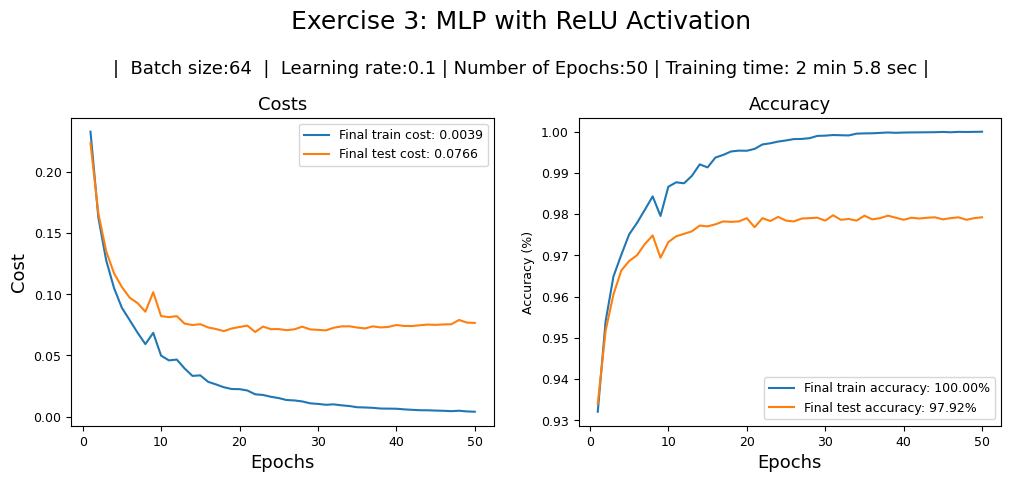

In [61]:
import time
start_time = time.time()

# Train with ReLU
w_relu, b_relu, t_costs_r, v_costs_r, t_accs_r, v_accs_r = train_model(
    x_train, y_train, x_test, y_test,
    model_architecture=arch_mlp,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    batch_size=batch_size,
    activation_type='ReLU'
)

training_curve_plot(
    "Exercise 3: MLP with ReLU Activation",
    t_costs_r, v_costs_r, t_accs_r, v_accs_r,
    batch_size, learning_rate, num_epochs, time.time() - start_time
)

Training [784, 128, 10] using sigmoid for 50 epochs...
Epoch 0: Loss 0.3936, Test Acc 0.8996
Epoch 1: Loss 0.3188, Test Acc 0.9133
Epoch 2: Loss 0.2910, Test Acc 0.9199
Epoch 3: Loss 0.2669, Test Acc 0.9257
Epoch 4: Loss 0.2473, Test Acc 0.9316
Epoch 5: Loss 0.2312, Test Acc 0.9362
Epoch 6: Loss 0.2165, Test Acc 0.9384
Epoch 7: Loss 0.2073, Test Acc 0.9404
Epoch 8: Loss 0.1937, Test Acc 0.9444
Epoch 9: Loss 0.1849, Test Acc 0.9445
Epoch 10: Loss 0.1746, Test Acc 0.9477
Epoch 11: Loss 0.1651, Test Acc 0.9501
Epoch 12: Loss 0.1572, Test Acc 0.9523
Epoch 13: Loss 0.1517, Test Acc 0.9530
Epoch 14: Loss 0.1459, Test Acc 0.9555
Epoch 15: Loss 0.1385, Test Acc 0.9574
Epoch 16: Loss 0.1323, Test Acc 0.9583
Epoch 17: Loss 0.1280, Test Acc 0.9596
Epoch 18: Loss 0.1241, Test Acc 0.9596
Epoch 19: Loss 0.1194, Test Acc 0.9623
Epoch 20: Loss 0.1167, Test Acc 0.9621
Epoch 21: Loss 0.1104, Test Acc 0.9634
Epoch 22: Loss 0.1064, Test Acc 0.9649
Epoch 23: Loss 0.1045, Test Acc 0.9650
Epoch 24: Loss 0.10

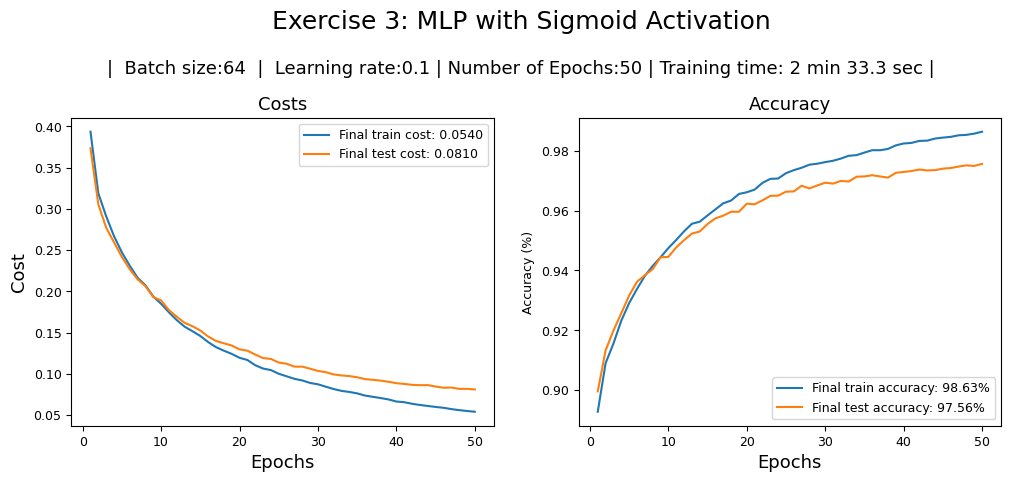

In [62]:
start_time = time.time()

# Train with Sigmoid
w_sig, b_sig, t_costs_s, v_costs_s, t_accs_s, v_accs_s = train_model(
    x_train, y_train, x_test, y_test,
    model_architecture=arch_mlp,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    batch_size=batch_size,
    activation_type='sigmoid'
)

training_curve_plot(
    "Exercise 3: MLP with Sigmoid Activation",
    t_costs_s, v_costs_s, t_accs_s, v_accs_s,
    batch_size, learning_rate, num_epochs, time.time() - start_time
)